# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**: Gianna Weidman

**ID**: grw64

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Local/Coding Projects/BEE4570/hw2-me-myself-and-i`


In [3]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 $m^3$).

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.


**My Solution**

To start, define some different control volumes.
1. At the place where the River meets Discharge #1
2. The River section between the two Discharge points
3. Where the River meets Discharge #2

Assume that the discharge points are points, aka there's no decay due to distance/time within the discharge point.

The code starts by defining some given information on flow rates and CRUD concentrations. 


The system does seem to be in compliance with the regulatory limit. Since the concentration of CRUD right after passing the 2nd discharge point is 2.007 kg/1000 $m^3$ , based on what is given in terms of the decay rate, the concentration will only decrease with time.

In [4]:
# Given information
Qr = 250000     # River flow rate (m3/day)
Cr = 0.5        # CRUD (/1000m3)

Q1 = 40000      # Discharge 1 flow (m3/day)
C1 = 9          # CRUD (/1000m3)

# Mass balance on the first control volume
Qr2 = Qr + Q1
Cr2 = (Qr*Cr + Q1*C1)/Qr2   # CRUD (/1000m3)

# Convert decay rate to vary as a function of distance using river flow rate given (10 km/d)
dr = 0.36 * 1/10     # decay rate: /km

# Exponential decay function
function decay(C0, d)
    """
    C0: intial CRUD concentration
    d:  the distance traveled
    """

    return C0 * exp(-dr * d)

end

# CRUD concentration change by end of 2nd control volume
Cr3 = decay(Cr2, 15)

# Given information
Q2 = 60000      # Discharge 2 flow (m3/day)
C2 = 7          # CRUD (/1000m3)

# Mass balance on 3rd control volume
Qr4 = Qr2 + Q2
Cr4 = (Qr2*Cr3 + Q2*C2)/Qr4

# Cr4 is the concentration by the end of the 3rd control volume
@show Cr4

Cr4 = 2.0075225782896715


2.0075225782896715

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

**Solution to Problem 2**

Referred to lecture slides to set up code. 

Based on the plot, it seems that there are equillibria where $X_t >= 0.5$ at $X = 1$ usually reached by 40 time steps, except for when $X_0 = 0.5$ where it took much longer to reach that point. There's also an equilbrium point at $X=0$ where $X_0 < 0.5$. This is generally reached by 20 time steps. I would say the system seems pretty resilient, but the pace at which the system returns to a steady state depends largely on where it started initially.

Upon repeating the analysis with a point-source being considered, the system dynamics changed such that it no longer had two equilibria: for the range of initial P concentrations considered, they all eventualyl returned to an equilibrium concentration of 1.82 [units P conc]. In this model, the lake also reached its equilibrium much faster, within as few as 15 timesteps for all $X_0$. This could be interpreted as the system being more resilient. 

In [83]:
# Code laying out the functions

recycling(x, q) = x.^q ./ (1 .+ x .^q)
outflow(x, b) = -1 .* b .* x

function P_simulation(X0, T, b, q, a, y)
    """
    X0: (float) initial P concentration in lake
    T:  (int)   number of timesteps to model
    b:  (float) linear rate of P flow
    q:  (float) parameter for P recycling
    q:  (array) point source releases
    y:  (array) non-point source releases
    """

    # make empty array for X based off time frame T
    X = zeros(T)
    
    # set initial X as given X0
    X[1] = X0

    # iterate through timesteps for change in X
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t] .+ recycling(X[t-1], q) .+ outflow(X[t-1], b)
    end

    return X
end

P_simulation (generic function with 1 method)

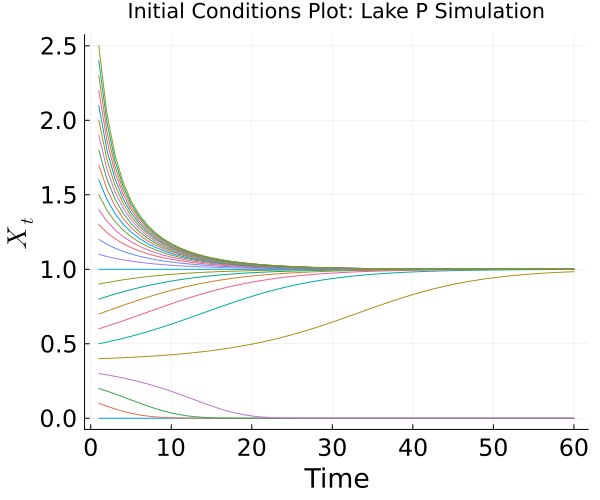

In [84]:
# Code displaying the first plot

using Plots

# Set parameters
T = 60
q = 1.5
b = 0.5
a = zeros(T)
y = zeros(T)
X_vals = collect(0:0.1:2.5)

X = map(x -> P_simulation(x, T, b, q, a, y), X_vals)

p_noinflow = plot(X, label=false, title="Initial Conditions Plot: Lake P Simulation", ylabel=L"X_t", xlabel="Time", guidefontsize=18, 
        tickfontsize=16, size=(600, 500))#, left_margin=5, bottom_margin=5)

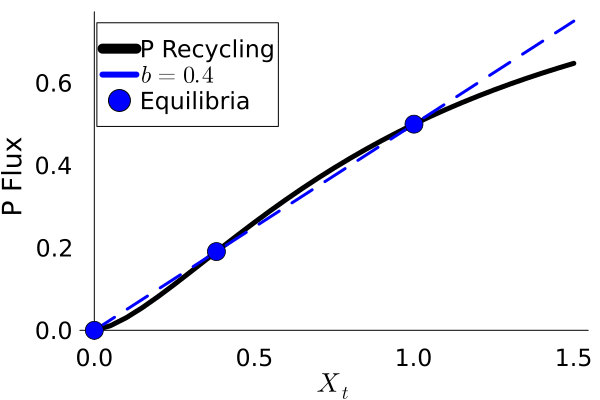

In [85]:
# Code for first dynamics plot 

# set Xt range
x = 0:0.05:1.5;

# Plot recycling and outflow curves
p1 = plot(x, recycling(x, q), color=:black, linewidth=5,legend=:topleft, label="P Recycling", ylabel="P Flux", xlabel=L"$X_t$", tickfontsize=16, guidefontsize=18, legendfontsize=16, palette=:tol_muted, framestyle=:zerolines, grid=:false)
plot!(x, -outflow(x, b), linewidth=3, linestyle=:dash, label=L"$b=0.5$", color=:blue)

# Eq1s found from below code and placed up here to appear on the plot
eq1 = [0.0, 0.382, 1.0]
scatter!(p1, eq1, (y -> recycling(y,q)).(eq1), label="Equilibria", markersize=10, markercolor=:blue)

In [86]:
# Code for finding equilibria
X_delta(x, a, q, b) = a .+ recycling(x, q) .+ outflow(x, b)

# First root
r1 = Roots.find_zero(x -> X_delta(x, a, q, b), 1.5)

# Second root
r2 = Roots.find_zero(x -> X_delta(x, a, q, b), 0.4)

# Third root
r3 = Roots.find_zero(x -> X_delta(x, a, q, b), 0.0)

print(r1, "\n", r2, "\n", r3)

1.0
0.3819660112501052
0.0

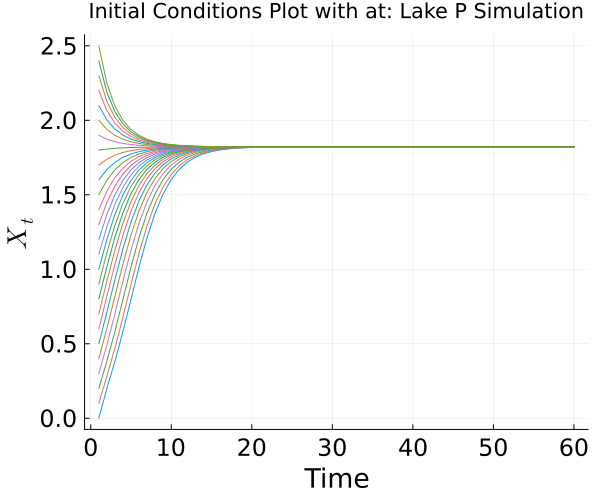

In [87]:
# Code changing at to 0.2 for all t
T = 60
a = zeros(T) .+ 0.2

X = map(x -> P_simulation(x, T, b, q, a, y), X_vals)

p_noinflow = plot(X, label=false, title="Initial Conditions Plot with at: Lake P Simulation", ylabel=L"X_t", xlabel="Time", guidefontsize=18, 
        tickfontsize=16, size=(600, 500))#, left_margin=5, bottom_margin=5)

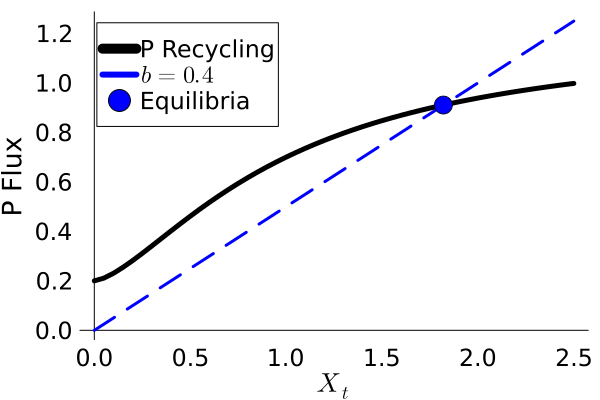

In [102]:
# New dynamics plot and Find new equilibrium

# define a function inflows (might be redundant now)
inflows(x,q,a) = a .+ recycling(x,q)

# set Xt range
x = 0:0.05:2.5;

# a of proper size
a2 = zeros(length(x)) .+ 0.2

# Plot recycling and outflow curves
p1 = plot(x, inflows(x, q, a2), color=:black, linewidth=5,legend=:topleft, label="P Recycling", ylabel="P Flux", xlabel=L"$X_t$", tickfontsize=16, guidefontsize=18, legendfontsize=16, palette=:tol_muted, framestyle=:zerolines, grid=:false)
plot!(x, -outflow(x, b), linewidth=3, linestyle=:dash, label=L"$b=0.5$", color=:blue)

# Eq1s found from below code and placed up here to appear on the plot
eq1 = [1.82]
scatter!(p1, eq1, (y -> inflows(y,q,a2)).(eq1), label="Equilibria", markersize=10, markercolor=:blue)

In [103]:
r1 = Roots.find_zero(x -> X_delta(x, a, q, b), 1.5)
@show r1

r1 = 1.8217865862160372


1.8217865862160372

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.

 - Referred to class slides for assistance writing code for Problem 2